# Deployment

In this series we've been exploring a structured controller development workflow.

```{image} _static/dev_workflow.png
:class: only-light
```

```{image} _static/dev_workflow_dark.png
:class: only-dark
```

So far we've covered:

1. Specification of the physical system ([Part 1](../../../notebooks/workflow/workflow01.md))
2. Characterization of the system ([Part 2](workflow02.md))
3. Controller design and simulation ([Part 3](workflow03.md))
4. HIL testing validation ([Part 4](workflow04.md))

All that's left is to run the controller on the actual hardware!

This final entry in the series will be much lighter than the previous parts, because we've already done the hard work.
By including the HIL testing stage and being careful to construct a plant model that precisely matches the I/O of the physical system, all we need to do is swap the leads from the HIL board to the motor control circuit and re-run the test sequence.

The circuit is the same as the one we used for the step response in [Part 2](workflow02.md):

```{image} _static/ctrl_schematic.png
```

## Analyzing the experimental results

We can also re-use the serial communication script to collect the test data:

```bash
python serial_receive.py --save deployed_data.csv
```

How does the real thing compare to simulation and HIL test?

In [1]:
# ruff: noqa: N802, N803, N806, N815, N816
import os

import matplotlib.pyplot as plt
import numpy as np

import archimedes as arc

THEME = os.environ.get("ARCHIMEDES_THEME", "dark")
arc.theme.set_theme(THEME)

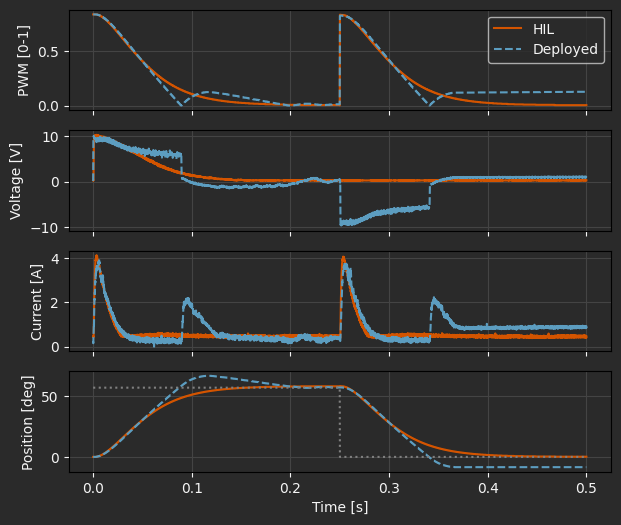

In [2]:
hil_data = np.loadtxt("data/hil_data.csv", delimiter="\t", skiprows=1)
sim_data = np.loadtxt("data/sim_data.csv", delimiter="\t", skiprows=1)
expt_data = np.loadtxt("data/deployed_data.csv", delimiter="\t", skiprows=1)

pos_cmd = np.zeros_like(hil_data[:, 0])
pos_cmd[hil_data[:, 0] <= hil_data[:, 0].max() / 2] = np.degrees(1.0)

fig, ax = plt.subplots(4, 1, figsize=(7, 6), sharex=True)

ax[0].plot(hil_data[:, 0], hil_data[:, 1], label="HIL")
ax[0].plot(expt_data[:, 0], expt_data[:, 1], "--", label="Deployed")
ax[0].set_ylabel("PWM [0-1]")
ax[0].grid()
ax[0].legend()

ax[1].plot(hil_data[:, 0], hil_data[:, 2])
ax[1].plot(expt_data[:, 0], expt_data[:, 2], "--", label="Deployed")
ax[1].set_ylabel("Voltage [V]")
ax[1].grid()

ax[2].plot(hil_data[:, 0], hil_data[:, 3])
ax[2].plot(expt_data[:, 0], expt_data[:, 3], "--", label="Deployed")
ax[2].set_ylabel("Current [A]")
ax[2].grid()

ax[3].plot(hil_data[:, 0], hil_data[:, 4])
ax[3].plot(expt_data[:, 0], expt_data[:, 4], "--", label="Deployed")
ax[3].plot(hil_data[:, 0], pos_cmd, ":", color="gray", label="Command")
ax[3].set_ylabel("Position [deg]")
ax[3].grid()

ax[-1].set_xlabel("Time [s]")

plt.show()

The correspondence here is not quite as good as it was between HIL and simulation.
To some extent, this is to be expected - after all, we're now running with the real physics.
On the other hand, our calibrated model matched the step response data quite well, and we're still mostly avoiding regimes where unmodeled effects like static friction and backlash would play a major role.
So it's worth taking a moment to inspect these results and see if we can identify the source of the divergence.

The simplest relationship in this data is between PWM duty cycle and voltage.  The idealized relationship is a linear model

$$
V(t) = V_0 u(t), \qquad u \in (-1, 1),
$$

where $V_0$ is the supply voltage.
We were able to roughly confirm this with the ramp test in [Part 2](workflow02.md).

In reality though, the supplied voltage to the motor stays persistently _above_ the predicted value from 60-80 ms, even as the PWM duty cycle drops _below_ the simulation trace as the feedback controller tries to decrease the input voltage.
Then there is a sharp drop in voltage as the control signal crosses zero and the polarity flips, leading to a spike in current and an overshoot of the target position.

This causal analysis immediately lets us zero in on the main source of the discrepancy!
Some part of the power system (most likely the cheap 12V "wall wart" supply) has its own internal dynamics, causing $V(t)$ to lag behind $u(t)$.
Most of the other deviations follow directly from this behavior.

The other discrepancy we might notice is a persistent position error towards the end of the test sequence.
Again, we can quickly zero in on the problem.
The persistent small error leads the PI controller to output a 10-15% duty cycle and corresponding current (slowly increasing due to integral action), but the position does not appear to respond.
However, referring back to the "non-ideal effects" explored at the end of [Part 2](workflow02.md), we can guess that this is solidly in the static friction regime, where additional torque will have no effect on position until the "breakaway torque" threshold.

The observation that the power supply has unmodeled internal dynamics and that static friction causes problems for accurate position tracking with a pure PI controller are enough to send us on another iteration of the design loop.
We might proceed by:

1. Designing characterization tests that will highlight the unmodeled (like a chirp response)
2. Adding non-ideal effects like Coulomb friction and power supply dynamics to the physics model
3. Calibrating parameters of the non-ideal model using the new test data
4. Revising the control architecture to consider static friction and power supply effects
5. Re-doing the HIL and deployment tests with the revised model and controller

All of this development can proceed with the same workflow we've already followed; we just go back to the top and add another level of fidelity.
The advantage of this kind of structured development workflow is not that you don't need to iterate, it's that the iteration can happen at a faster pace because of the direct path from your Python code to hardware deployment.

## Lessons learned

We've already seen two examples of how this approach to control systems development can pay dividends in troublshooting and rapid iteration.
First, at the end of [Part 4](workflow04.md) we gave a brief anecdote about a misadventure in premature optimization of the control algorithm (the IMC-tuned cascaded controller).
This controller looked good on paper, but fell apart as soon as it was put into HIL testing, giving us quick and easy feedback that it was not going to work in practice.

Then, by comparing the HIL results with the actual motor performance, we were able to quickly zero in on two problem areas for the physics model and controller, without needing to do any hardware troubleshooting.
One key is the incremental nature of the development; since each stage from simulation to HIL testing to deployment is limited in scope, the number of possibilities for bugs and other problems is reduced.
The process is also accelerated by having a single "source of truth" in the Python code.
We can do parameter estimation, controller design, HIL testing, and hardware deployment using the same models and control algorithm.

## Where to go from here

This series builds on various Archimedes concepts, including:

* [C code generation](../../../notebooks/deployment/deployment00.md)
* [Structured data types](../../../trees.md)
* [Hierarchical modeling](../modular-design.md)
* [Parameter estimation](../sysid/parameter-estimation.md)

If you aren't familiar with any of these, this is a great time to dig deeper and see how these combine to enable this end-to-end development workflow.

But the obvious next step is to go build something!
How would you map your next project onto this workflow?
What would you keep, add, or customize to make it fit your needs and preferences?
While the path to hardware in Archimedes is still in the early stages of development, it is central to the Archimedes project.
**If you're using Archimedes for hardware development and have questions, comments, or requests, please don't hesitate to reach out!**